In [0]:
from keras.utils import np_utils 
from keras.datasets import mnist 
import seaborn as sns
from keras.initializers import RandomNormal

# https://deeplearningcourses.com/c/deep-learning-advanced-nlp
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

import warnings
import os
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Bidirectional, GlobalMaxPooling1D, Lambda, Concatenate, Dense
import keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
if len(K.tensorflow_backend._get_available_gpus()) > 0:
  from keras.layers import CuDNNLSTM as LSTM
  from keras.layers import CuDNNGRU as GRU

In [0]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [10, 8]
warnings.filterwarnings("ignore", category=FutureWarning)
%config InlineBackend.figure_format = 'retina'

In [0]:
# the data, shuffled and split between train and test sets 
(X_train_, y_train_), (X_test_, y_test_) = mnist.load_data()

In [18]:
print("Number of training examples :", X_train_.shape[0], "and each image is of shape (%d, %d)"%(X_train_.shape[1], X_train_.shape[2]))
print("Number of training examples :", X_test_.shape[0], "and each image is of shape (%d, %d)"%(X_test_.shape[1], X_test_.shape[2]))

Number of training examples : 60000 and each image is of shape (28, 28)
Number of training examples : 10000 and each image is of shape (28, 28)


In [19]:
#if we observe the above matrix each cell is having a value between 0-255
# before we move to apply machine learning algorithms lets try to normalize the data
# X => (X - Xmin)/(Xmax-Xmin) = X/255

X_train_ = X_train_/255
X_test_ = X_test_/255

# example data point after normlizing
print(X_train_[0])

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.    

# **Architecture-1**

input shape is: (?, 28, 28)
shape after putting the first one through lstm: (?, 28, 30)
shape after taking the maximum value: (?, 30)
after transposing each image, we get a output like Tensor("lambda_12/transpose:0", shape=(?, 28, 28), dtype=float32) with a shape (?, 28, 28)
shape after putting the second one through lstm: (?, 28, 30)
shape after taking the maximum value: (?, 30)
shape after concatenation (?, 60)
shape of output (?, 10)
Training model...

Epoch 00001: val_acc improved from -inf to 0.92830, saving model to best_model.h5

Epoch 00002: val_acc improved from 0.92830 to 0.95200, saving model to best_model.h5

Epoch 00003: val_acc improved from 0.95200 to 0.96050, saving model to best_model.h5

Epoch 00004: val_acc improved from 0.96050 to 0.96910, saving model to best_model.h5

Epoch 00005: val_acc improved from 0.96910 to 0.97290, saving model to best_model.h5

Epoch 00006: val_acc improved from 0.97290 to 0.97520, saving model to best_model.h5

Epoch 00007: val_acc did no

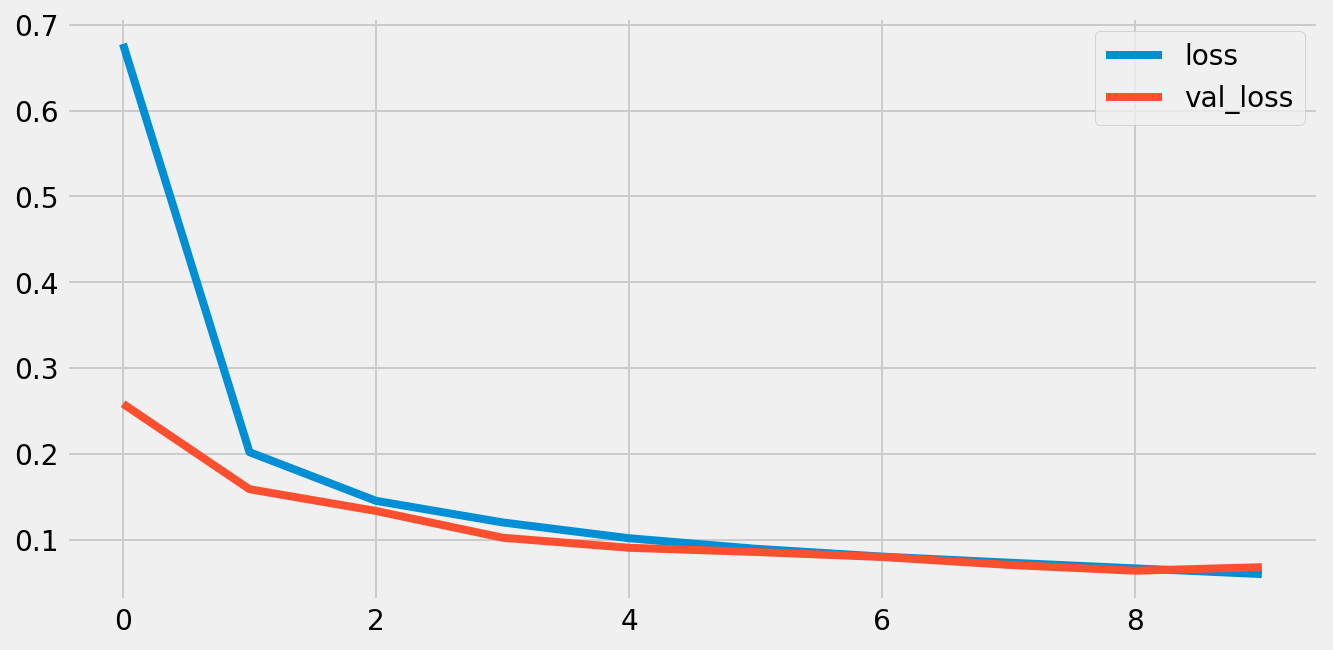

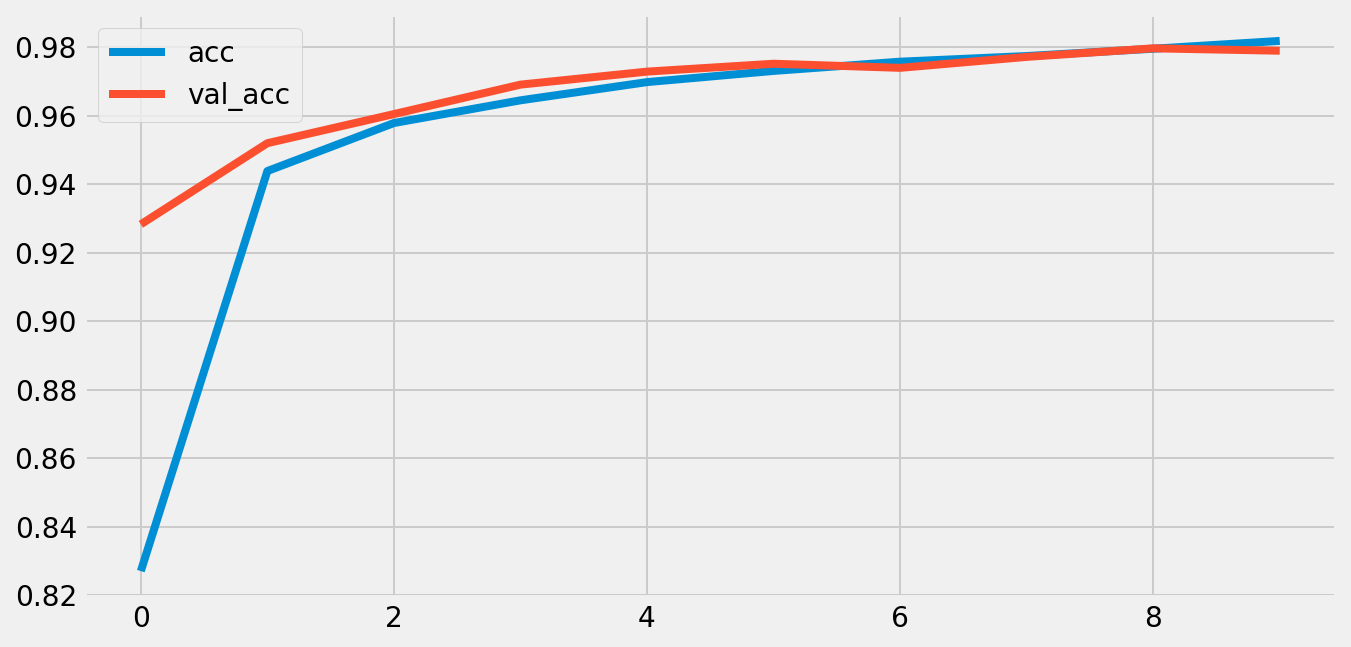

In [31]:
from keras.callbacks import ModelCheckpoint

# config
D = 28
M = 15


# input is an image of size 28x28
input_ = Input(shape=(D, D))
print('input shape is:', input_.shape)

# up-down
rnn1 = Bidirectional(LSTM(M, return_sequences=True))
x1 = rnn1(input_) # output is N x D x 2M
print('shape after putting the first one through lstm:', x1.shape)
x1 = GlobalMaxPooling1D()(x1) # output is N x 2M
print('shape after taking the maximum value:', x1.shape)

# left-right
rnn2 = Bidirectional(LSTM(M, return_sequences=True))

# custom layer
permutor = Lambda(lambda t: K.permute_dimensions(t, pattern=(0, 2, 1)))
x2 = permutor(input_)
print('after transposing each image, we get a output like', x2, 'with a shape', x2.shape)
x2 = rnn2(x2) # output is N x D x 2M
print('shape after putting the second one through lstm:', x2.shape)
x2 = GlobalMaxPooling1D()(x2) # output is N x 2M
print('shape after taking the maximum value:', x2.shape)
# put them together
concatenator = Concatenate(axis=1)
x = concatenator([x1, x2]) # output is N x 4M
print('shape after concatenation', x.shape)
# final dense layer
output = Dense(10, activation='softmax')(x)
print('shape of output',output.shape)
model = Model(inputs=input_, outputs=output)

# testing
# o = model.predict(X)
# print("o.shape:", o.shape)

# compile
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

# train
print('Training model...')
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
r = model.fit(X_train_, y_train_, batch_size = 64, epochs = 50, validation_data=(X_test_, y_test_), verbose=0, callbacks=[es, mc])
#history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test)) 


# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()


# Architecture-2

input shape is: (?, 28, 28)
shape after putting the first one through lstm: (?, 28, 200)
shape after taking the maximum value: (?, 200)
after transposing each image, we get a output like Tensor("lambda_14/transpose:0", shape=(?, 28, 28), dtype=float32) with a shape (?, 28, 28)
shape after putting the second one through lstm: (?, 28, 200)
shape after taking the maximum value: (?, 200)
shape after concatenation (?, 400)
shape of output (?, 10)
Training model...

Epoch 00001: val_acc improved from -inf to 0.97140, saving model to best_model_a2.h5

Epoch 00002: val_acc improved from 0.97140 to 0.97490, saving model to best_model_a2.h5

Epoch 00003: val_acc improved from 0.97490 to 0.98260, saving model to best_model_a2.h5

Epoch 00004: val_acc improved from 0.98260 to 0.98320, saving model to best_model_a2.h5

Epoch 00005: val_acc improved from 0.98320 to 0.98570, saving model to best_model_a2.h5

Epoch 00006: val_acc did not improve from 0.98570
Epoch 00006: early stopping


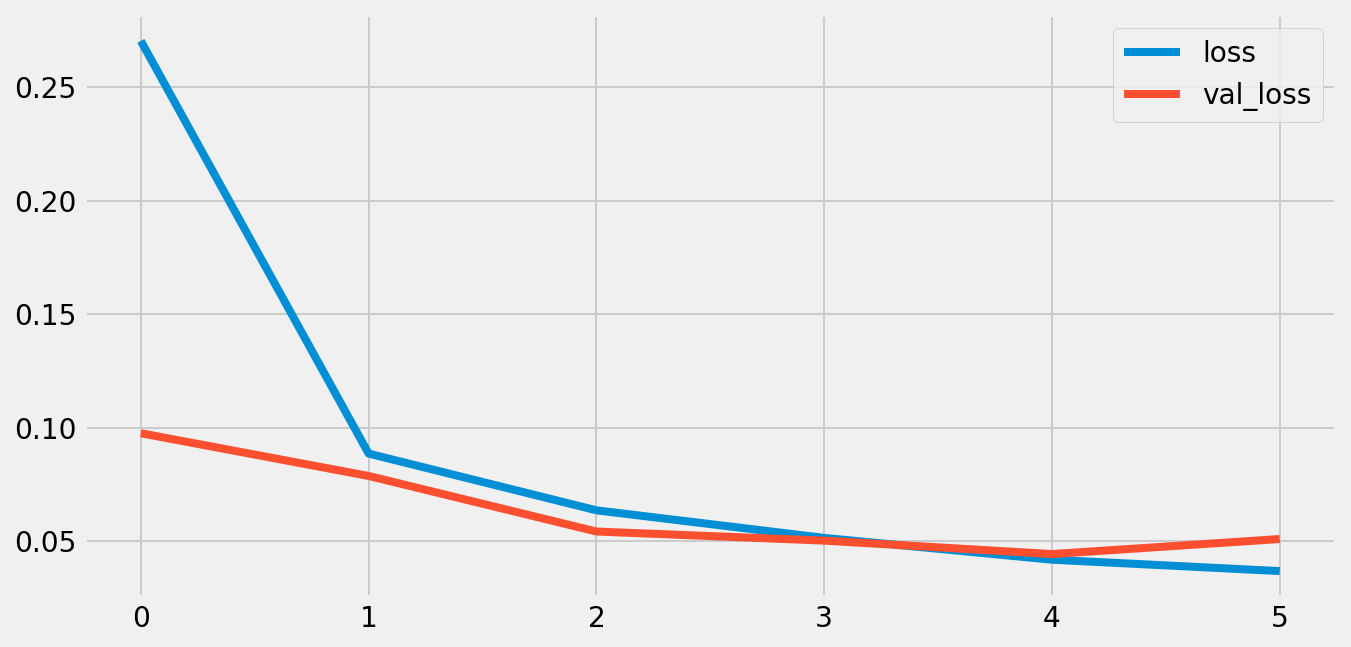

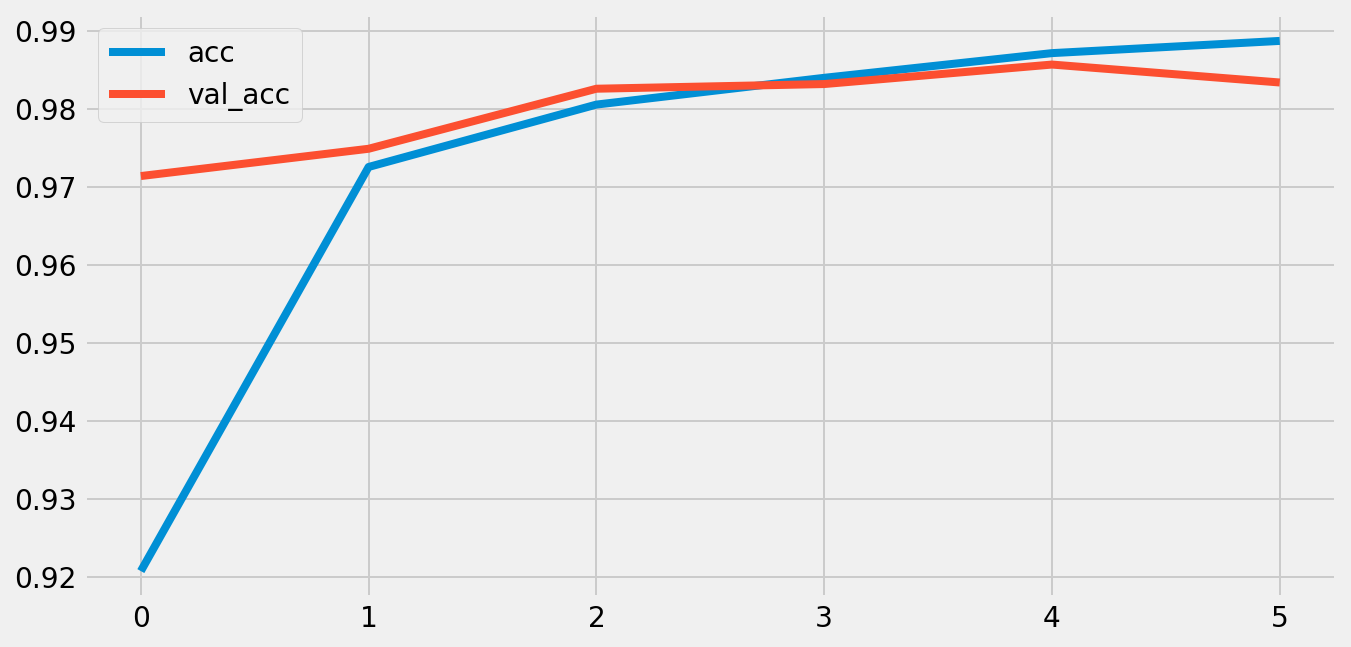

In [35]:
from keras.callbacks import ModelCheckpoint

# config
D = 28
M = 100


# input is an image of size 28x28
input_ = Input(shape=(D, D))
print('input shape is:', input_.shape)

# up-down
rnn1 = Bidirectional(LSTM(M, return_sequences=True))
x1 = rnn1(input_) # output is N x D x 2M
print('shape after putting the first one through lstm:', x1.shape)
x1 = GlobalMaxPooling1D()(x1) # output is N x 2M
print('shape after taking the maximum value:', x1.shape)

# left-right
rnn2 = Bidirectional(LSTM(M, return_sequences=True))

# custom layer
permutor = Lambda(lambda t: K.permute_dimensions(t, pattern=(0, 2, 1)))
x2 = permutor(input_)
print('after transposing each image, we get a output like', x2, 'with a shape', x2.shape)
x2 = rnn2(x2) # output is N x D x 2M
print('shape after putting the second one through lstm:', x2.shape)
x2 = GlobalMaxPooling1D()(x2) # output is N x 2M
print('shape after taking the maximum value:', x2.shape)
# put them together
concatenator = Concatenate(axis=1)
x = concatenator([x1, x2]) # output is N x 4M
print('shape after concatenation', x.shape)
# final dense layer
output = Dense(10, activation='softmax')(x)
print('shape of output',output.shape)
model = Model(inputs=input_, outputs=output)

# testing
# o = model.predict(X)
# print("o.shape:", o.shape)

# compile
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

# train
print('Training model...')
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
mc = ModelCheckpoint('best_model_a2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
r = model.fit(X_train_, y_train_, batch_size = 64, epochs = 50, validation_data=(X_test_, y_test_), verbose=0, callbacks=[es, mc])
#history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test)) 


# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()


# Architecture-3


input shape is: (?, 28, 28)
shape after putting the first one through lstm: (?, 28, 200)
shape after taking the maximum value: (?, 200)
after transposing each image, we get a output like Tensor("lambda_15/transpose:0", shape=(?, 28, 28), dtype=float32) with a shape (?, 28, 28)
shape after putting the second one through lstm: (?, 28, 200)
shape after taking the maximum value: (?, 200)
shape after concatenation (?, 400)
shape of output (?, 100)
Training model...

Epoch 00001: val_acc improved from -inf to 0.96650, saving model to best_model_a3.h5

Epoch 00002: val_acc improved from 0.96650 to 0.97490, saving model to best_model_a3.h5

Epoch 00003: val_acc improved from 0.97490 to 0.98030, saving model to best_model_a3.h5

Epoch 00004: val_acc improved from 0.98030 to 0.98400, saving model to best_model_a3.h5

Epoch 00005: val_acc improved from 0.98400 to 0.98490, saving model to best_model_a3.h5

Epoch 00006: val_acc did not improve from 0.98490
Epoch 00006: early stopping


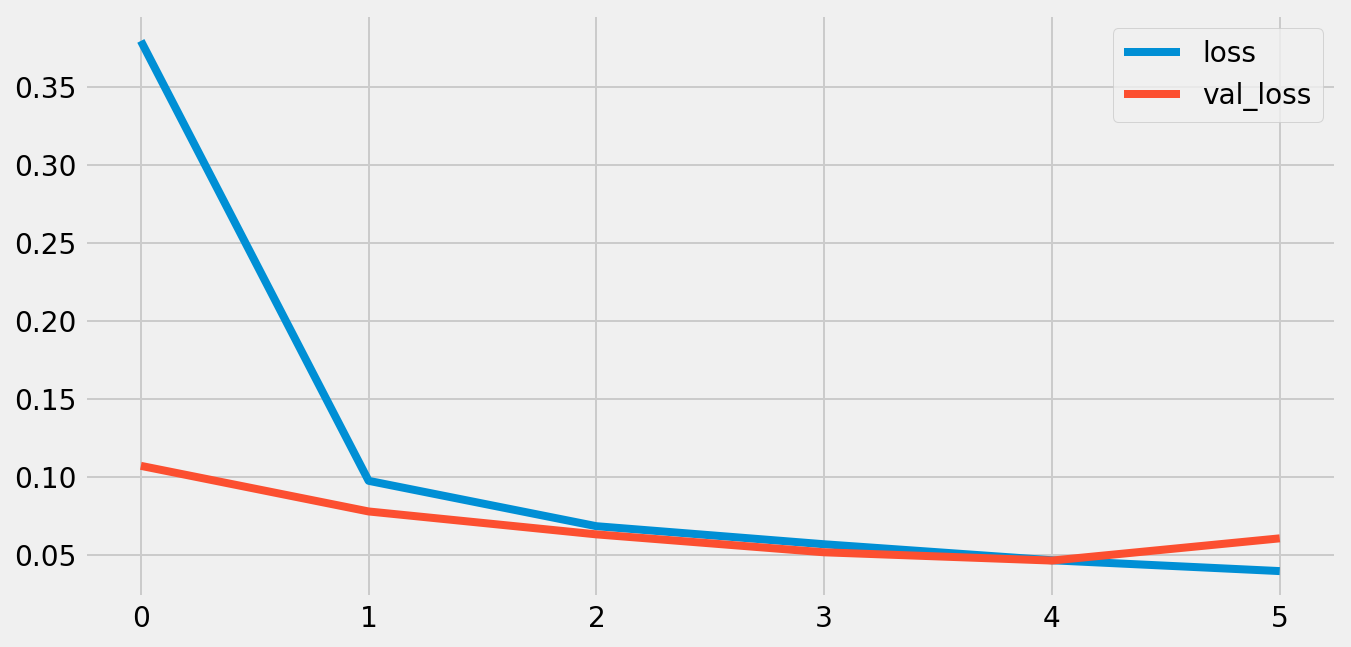

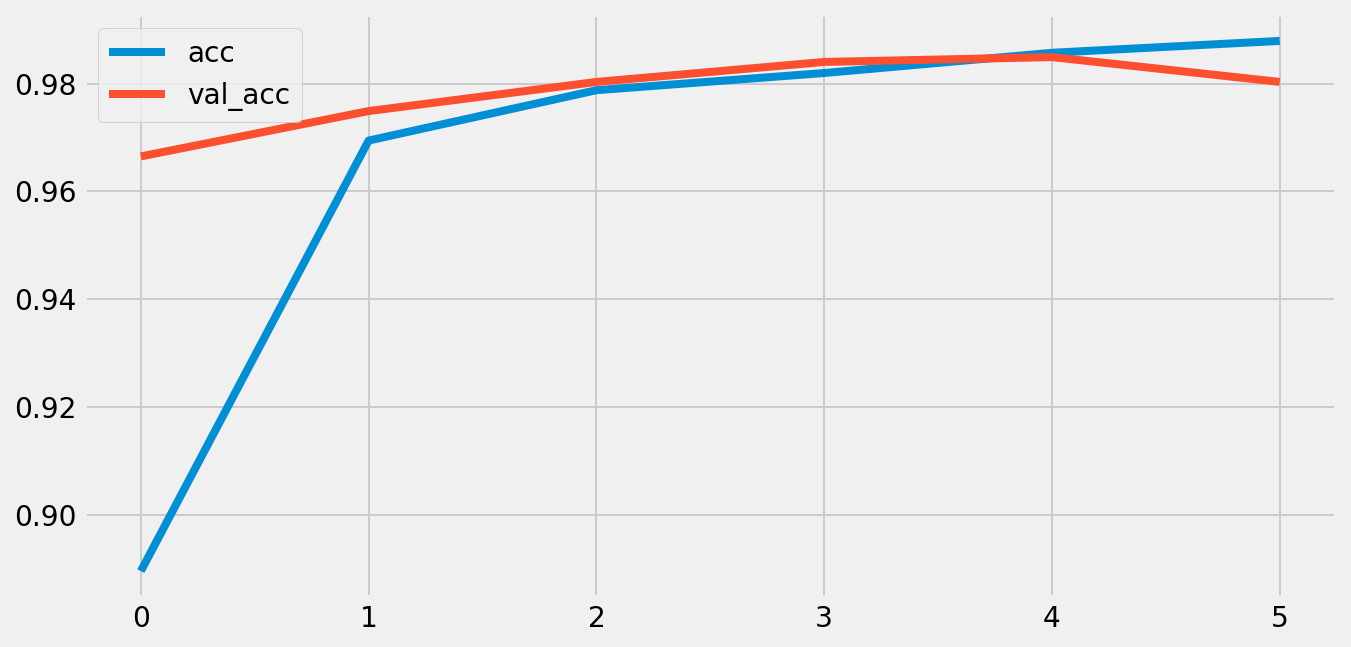

In [36]:
# config
D = 28
M = 100


# input is an image of size 28x28
input_ = Input(shape=(D, D))
print('input shape is:', input_.shape)

# up-down
rnn1 = Bidirectional(LSTM(M, return_sequences=True))
x1 = rnn1(input_) # output is N x D x 2M
print('shape after putting the first one through lstm:', x1.shape)
x1 = GlobalMaxPooling1D()(x1) # output is N x 2M
print('shape after taking the maximum value:', x1.shape)

# left-right
rnn2 = Bidirectional(LSTM(M, return_sequences=True))

# custom layer
permutor = Lambda(lambda t: K.permute_dimensions(t, pattern=(0, 2, 1)))
x2 = permutor(input_)
print('after transposing each image, we get a output like', x2, 'with a shape', x2.shape)
x2 = rnn2(x2) # output is N x D x 2M
print('shape after putting the second one through lstm:', x2.shape)
x2 = GlobalMaxPooling1D()(x2) # output is N x 2M
print('shape after taking the maximum value:', x2.shape)
# put them together
concatenator = Concatenate(axis=1)
x = concatenator([x1, x2]) # output is N x 4M
print('shape after concatenation', x.shape)
# final dense layer
output = Dense(100, activation='relu')(x)
output = Dense(100, activation='softmax')(output)
print('shape of output',output.shape)
model = Model(inputs=input_, outputs=output)

# testing
# o = model.predict(X)
# print("o.shape:", o.shape)

# compile
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

# train
print('Training model...')
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
mc = ModelCheckpoint('best_model_a3.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
r = model.fit(X_train_, y_train_, batch_size = 64, epochs = 50, validation_data=(X_test_, y_test_), verbose=0, callbacks=[es, mc])
#history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test)) 


# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()


# Architecture-4

In [0]:
from keras.layers import Dropout

input shape is: (?, 28, 28)
shape after putting the first one through lstm: (?, 28, 400)
shape after taking the maximum value: (?, 400)
after transposing each image, we get a output like Tensor("lambda_17/transpose:0", shape=(?, 28, 28), dtype=float32) with a shape (?, 28, 28)


W0626 09:27:02.340495 140084357248896 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


shape after putting the second one through lstm: (?, 28, 400)
shape after taking the maximum value: (?, 400)
shape after concatenation (?, 800)
shape of output (?, 100)
Training model...

Epoch 00001: val_acc improved from -inf to 0.96510, saving model to best_model_a4.h5

Epoch 00002: val_acc improved from 0.96510 to 0.97630, saving model to best_model_a4.h5

Epoch 00003: val_acc did not improve from 0.97630

Epoch 00004: val_acc improved from 0.97630 to 0.97960, saving model to best_model_a4.h5

Epoch 00005: val_acc improved from 0.97960 to 0.98230, saving model to best_model_a4.h5

Epoch 00006: val_acc improved from 0.98230 to 0.98260, saving model to best_model_a4.h5
Epoch 00006: early stopping


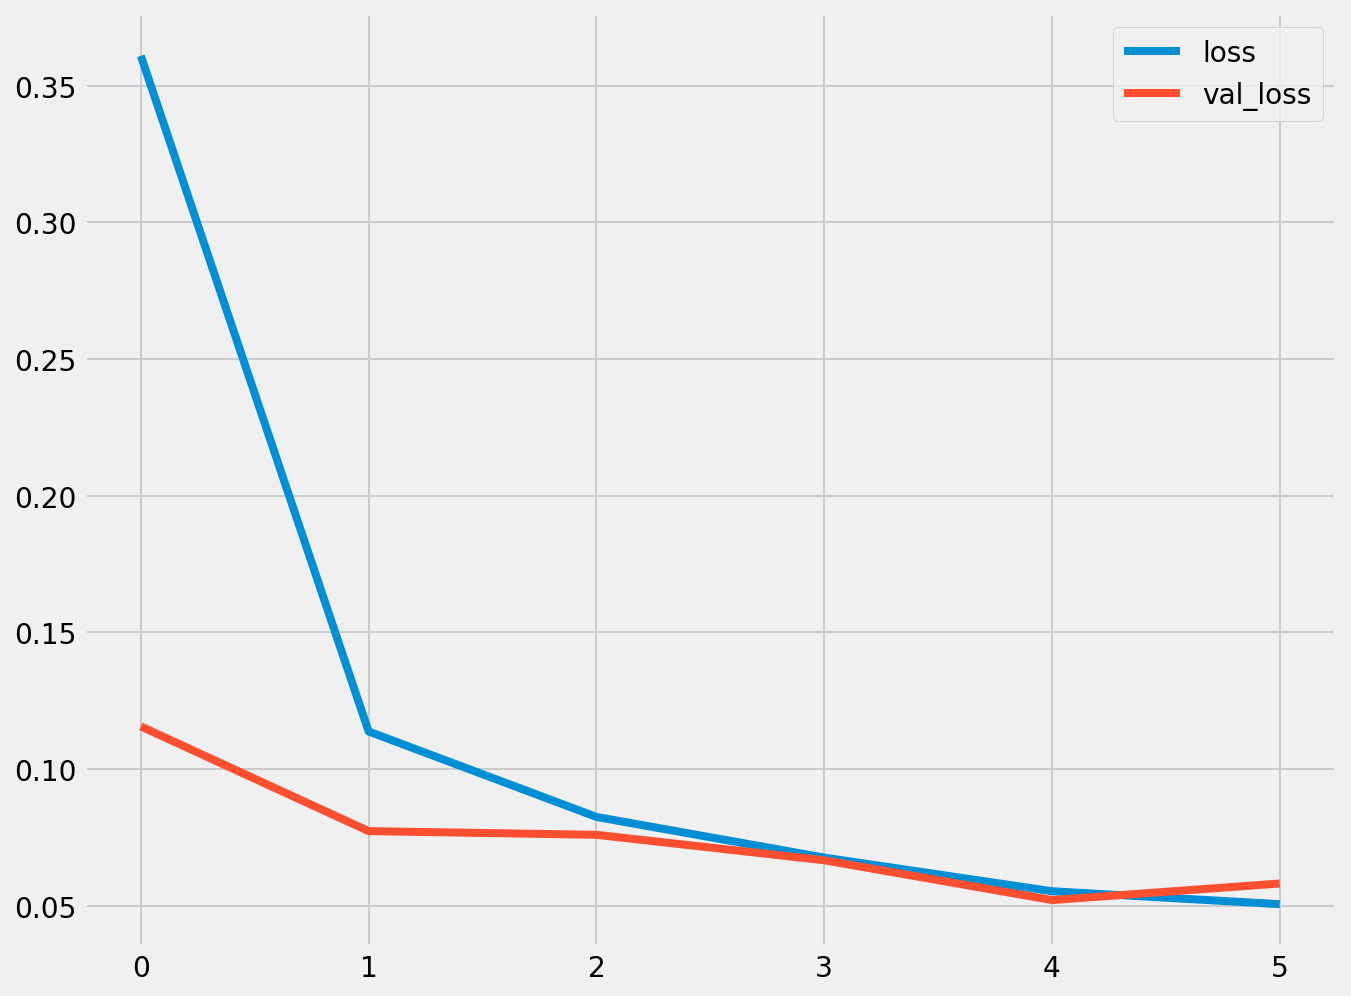

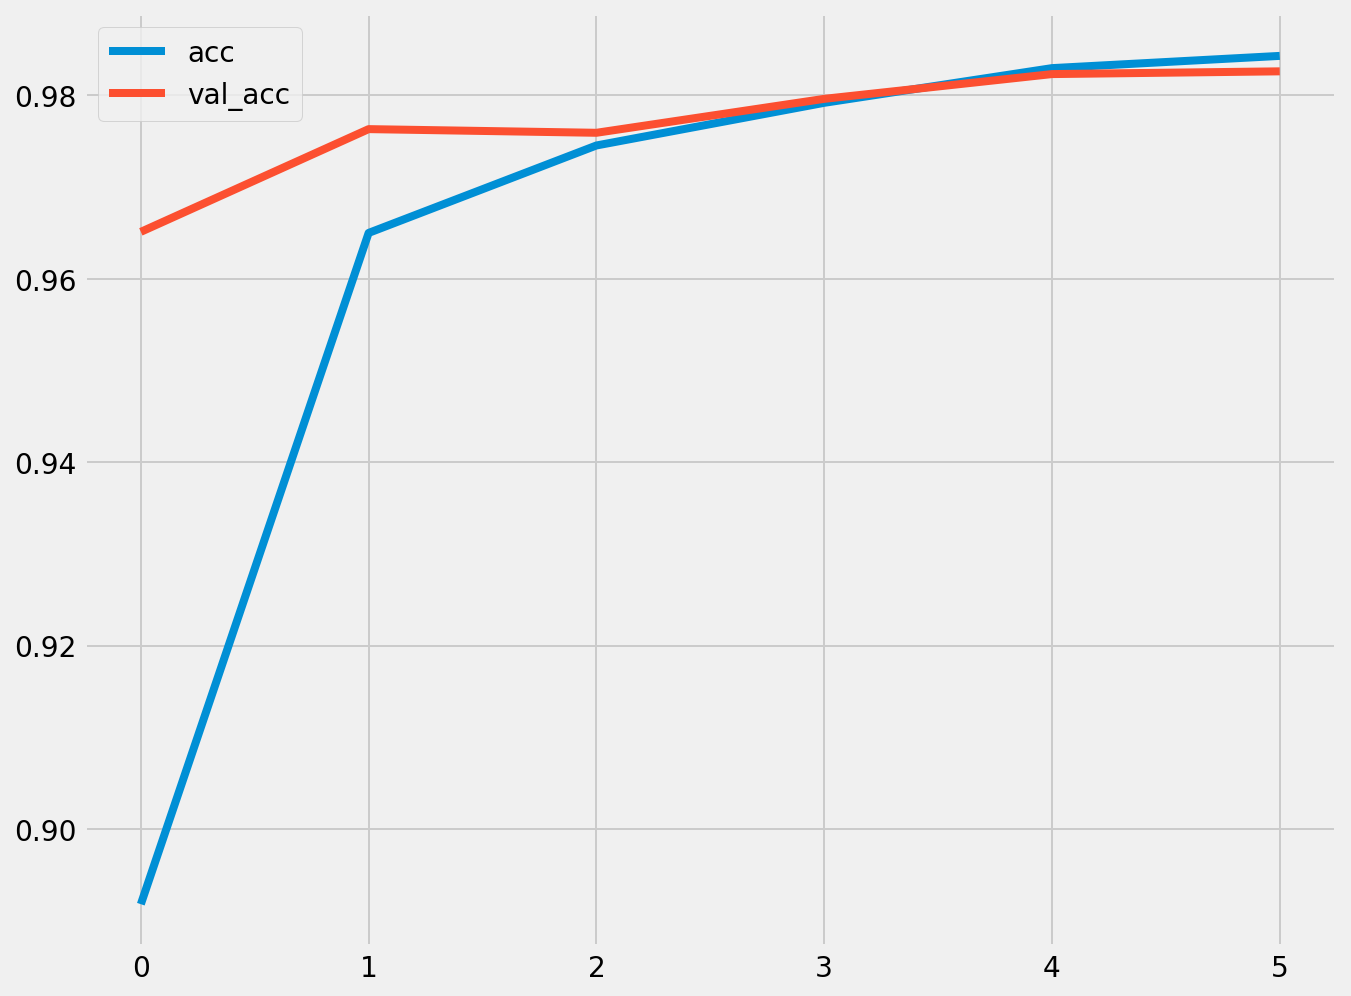

In [40]:
# config
D = 28
M = 200


# input is an image of size 28x28
input_ = Input(shape=(D, D))
print('input shape is:', input_.shape)

# up-down
rnn1 = Bidirectional(LSTM(M, return_sequences=True))
x1 = rnn1(input_) # output is N x D x 2M
print('shape after putting the first one through lstm:', x1.shape)
x1 = GlobalMaxPooling1D()(x1) # output is N x 2M
print('shape after taking the maximum value:', x1.shape)

# left-right
rnn2 = Bidirectional(LSTM(M, return_sequences=True))

# custom layer
permutor = Lambda(lambda t: K.permute_dimensions(t, pattern=(0, 2, 1)))
x2 = permutor(input_)
print('after transposing each image, we get a output like', x2, 'with a shape', x2.shape)
x2 = rnn2(x2) # output is N x D x 2M
print('shape after putting the second one through lstm:', x2.shape)
x2 = GlobalMaxPooling1D()(x2) # output is N x 2M
print('shape after taking the maximum value:', x2.shape)
# put them together
concatenator = Concatenate(axis=1)
x = concatenator([x1, x2]) # output is N x 4M
print('shape after concatenation', x.shape)
# final dense layer
x = Dropout(0.5)(x)
output = Dense(100, activation='relu')(x)
output = Dense(100, activation='softmax')(output)
print('shape of output',output.shape)
model = Model(inputs=input_, outputs=output)

# testing
# o = model.predict(X)
# print("o.shape:", o.shape)

# compile
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

# train
print('Training model...')
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
mc = ModelCheckpoint('best_model_a4.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
r = model.fit(X_train_, y_train_, batch_size = 64, epochs = 50, validation_data=(X_test_, y_test_), verbose=0, callbacks=[es, mc])
#history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test)) 


# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()


# Architecture -5

input shape is: (?, 28, 28)
shape after putting the first one through lstm: (?, 28, 400)
shape after taking the maximum value: (?, 400)
after transposing each image, we get a output like Tensor("lambda_18/transpose:0", shape=(?, 28, 28), dtype=float32) with a shape (?, 28, 28)
shape after putting the second one through lstm: (?, 28, 400)
shape after taking the maximum value: (?, 400)
shape after concatenation (?, 800)
shape of output (?, 100)
Training model...

Epoch 00001: val_acc improved from -inf to 0.96800, saving model to best_model_a5.h5

Epoch 00002: val_acc improved from 0.96800 to 0.97620, saving model to best_model_a5.h5

Epoch 00003: val_acc improved from 0.97620 to 0.98120, saving model to best_model_a5.h5

Epoch 00004: val_acc improved from 0.98120 to 0.98400, saving model to best_model_a5.h5

Epoch 00005: val_acc improved from 0.98400 to 0.98580, saving model to best_model_a5.h5
Epoch 00005: early stopping


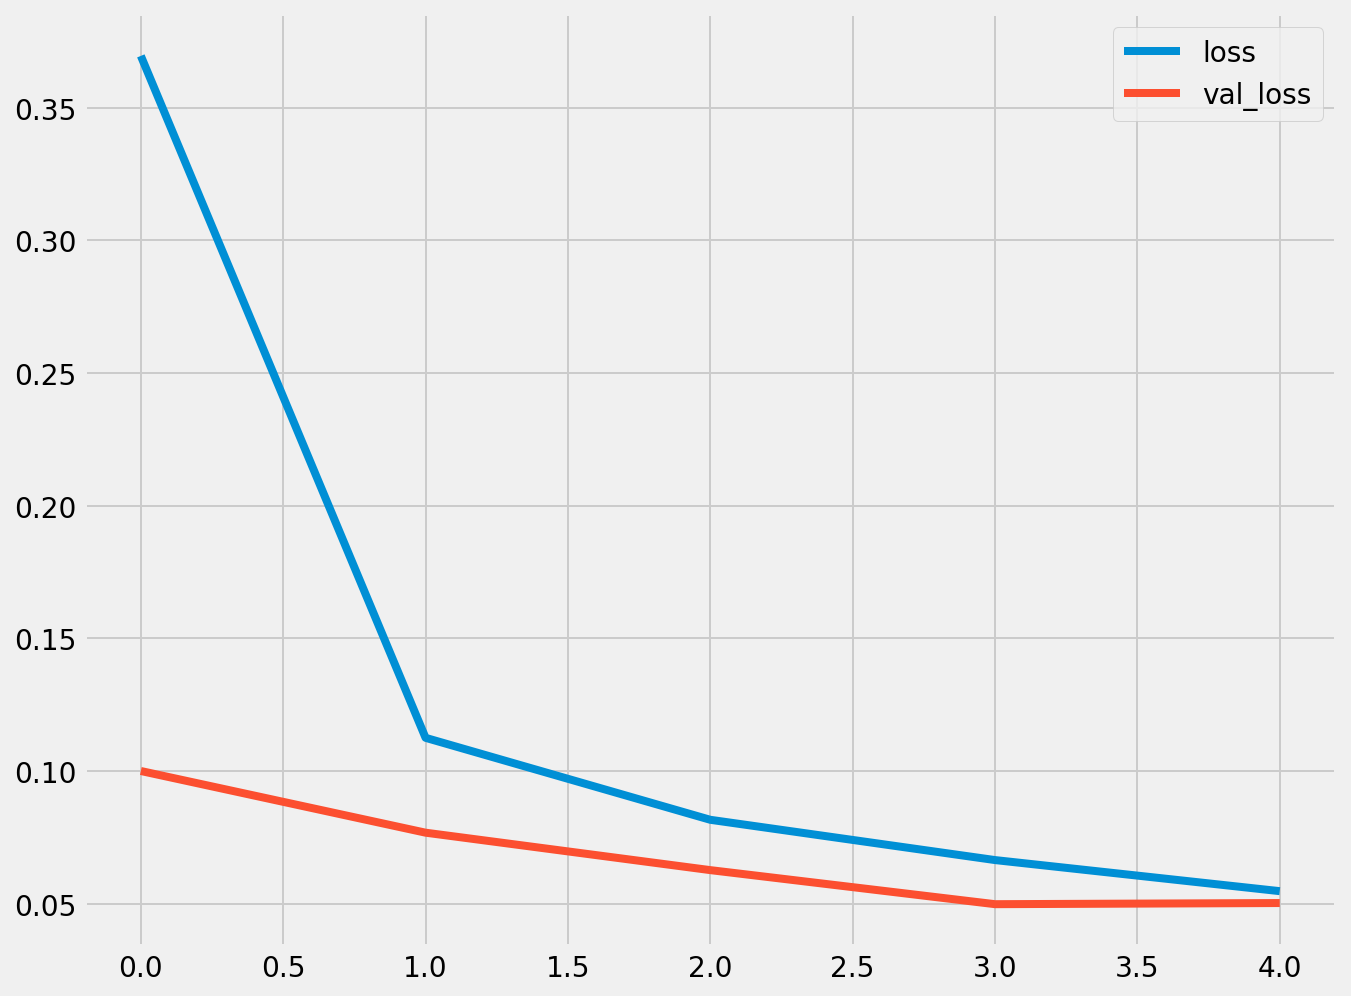

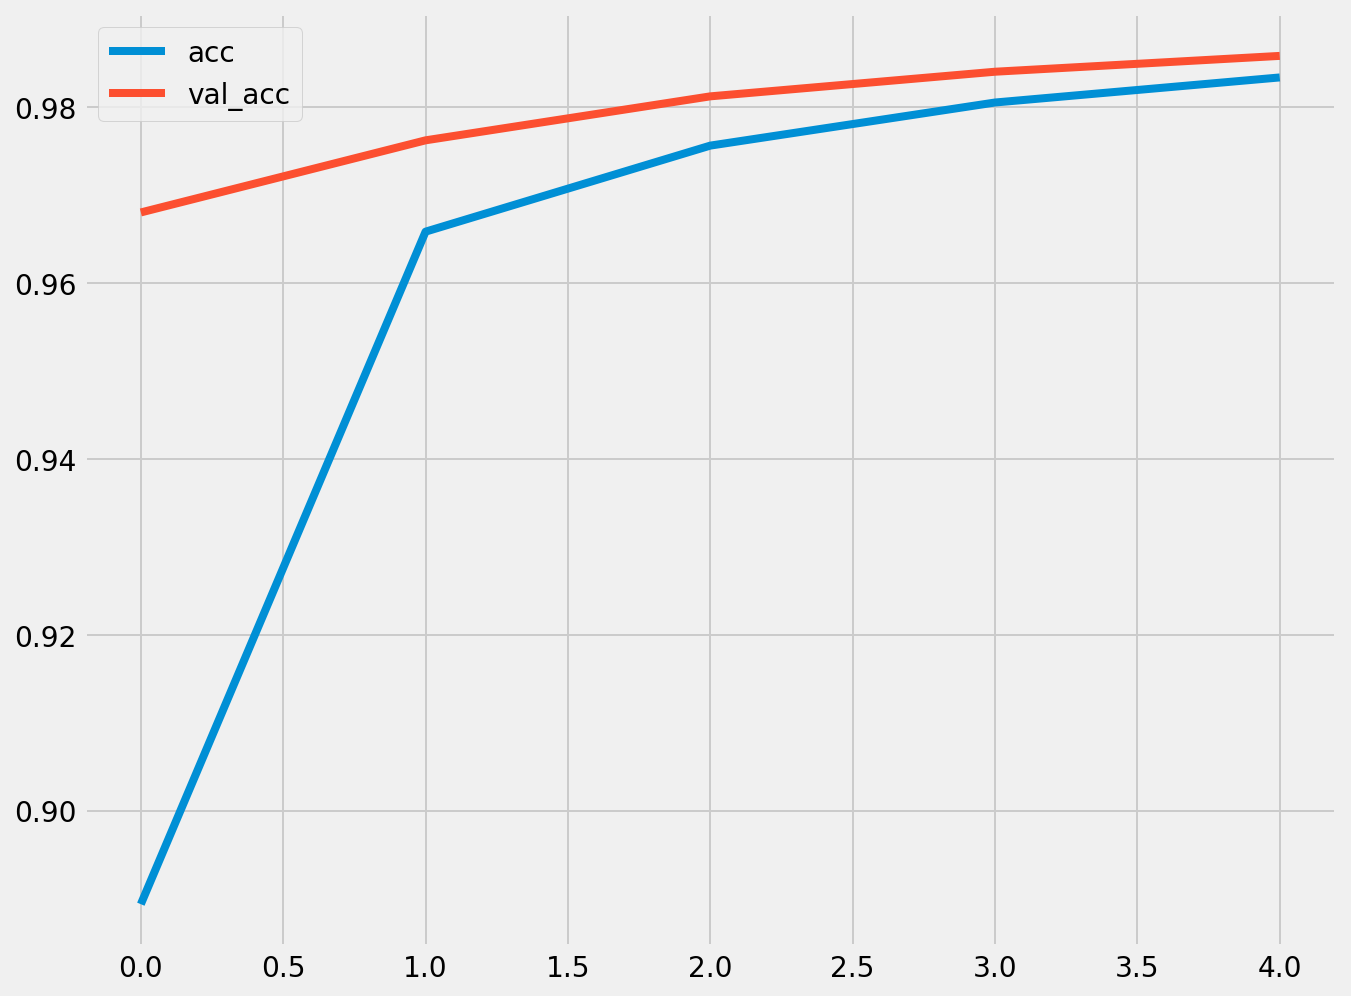

In [41]:
# config
D = 28
M = 200


# input is an image of size 28x28
input_ = Input(shape=(D, D))
print('input shape is:', input_.shape)

# up-down
rnn1 = Bidirectional(LSTM(M, return_sequences=True))
x1 = rnn1(input_) # output is N x D x 2M
print('shape after putting the first one through lstm:', x1.shape)
x1 = GlobalMaxPooling1D()(x1) # output is N x 2M
print('shape after taking the maximum value:', x1.shape)

# left-right
rnn2 = Bidirectional(LSTM(M, return_sequences=True))

# custom layer
permutor = Lambda(lambda t: K.permute_dimensions(t, pattern=(0, 2, 1)))
x2 = permutor(input_)
print('after transposing each image, we get a output like', x2, 'with a shape', x2.shape)
x2 = rnn2(x2) # output is N x D x 2M
print('shape after putting the second one through lstm:', x2.shape)
x2 = GlobalMaxPooling1D()(x2) # output is N x 2M
print('shape after taking the maximum value:', x2.shape)
# put them together
concatenator = Concatenate(axis=1)
x = concatenator([x1, x2]) # output is N x 4M
print('shape after concatenation', x.shape)
# final dense layer
x = Dropout(0.25)(x)
output = Dense(100, activation='relu')(x)
output = Dropout(0.25)(output)
output = Dense(100, activation='softmax')(output)
print('shape of output',output.shape)
model = Model(inputs=input_, outputs=output)

# testing
# o = model.predict(X)
# print("o.shape:", o.shape)

# compile
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

# train
print('Training model...')
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
mc = ModelCheckpoint('best_model_a5.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
r = model.fit(X_train_, y_train_, batch_size = 64, epochs = 50, validation_data=(X_test_, y_test_), verbose=0, callbacks=[es, mc])
#history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test)) 


# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()


# Architecture - 6

input shape is: (?, 28, 28)
shape after putting the first one through lstm: (?, 28, 400)
shape after taking the maximum value: (?, 400)
after transposing each image, we get a output like Tensor("lambda_19/transpose:0", shape=(?, 28, 28), dtype=float32) with a shape (?, 28, 28)
shape after putting the second one through lstm: (?, 28, 400)
shape after taking the maximum value: (?, 400)
shape after concatenation (?, 800)
shape of output (?, 10)
Training model...

Epoch 00001: val_acc improved from -inf to 0.95440, saving model to best_model_a6.h5

Epoch 00002: val_acc improved from 0.95440 to 0.96820, saving model to best_model_a6.h5

Epoch 00003: val_acc improved from 0.96820 to 0.97840, saving model to best_model_a6.h5

Epoch 00004: val_acc did not improve from 0.97840
Epoch 00004: early stopping


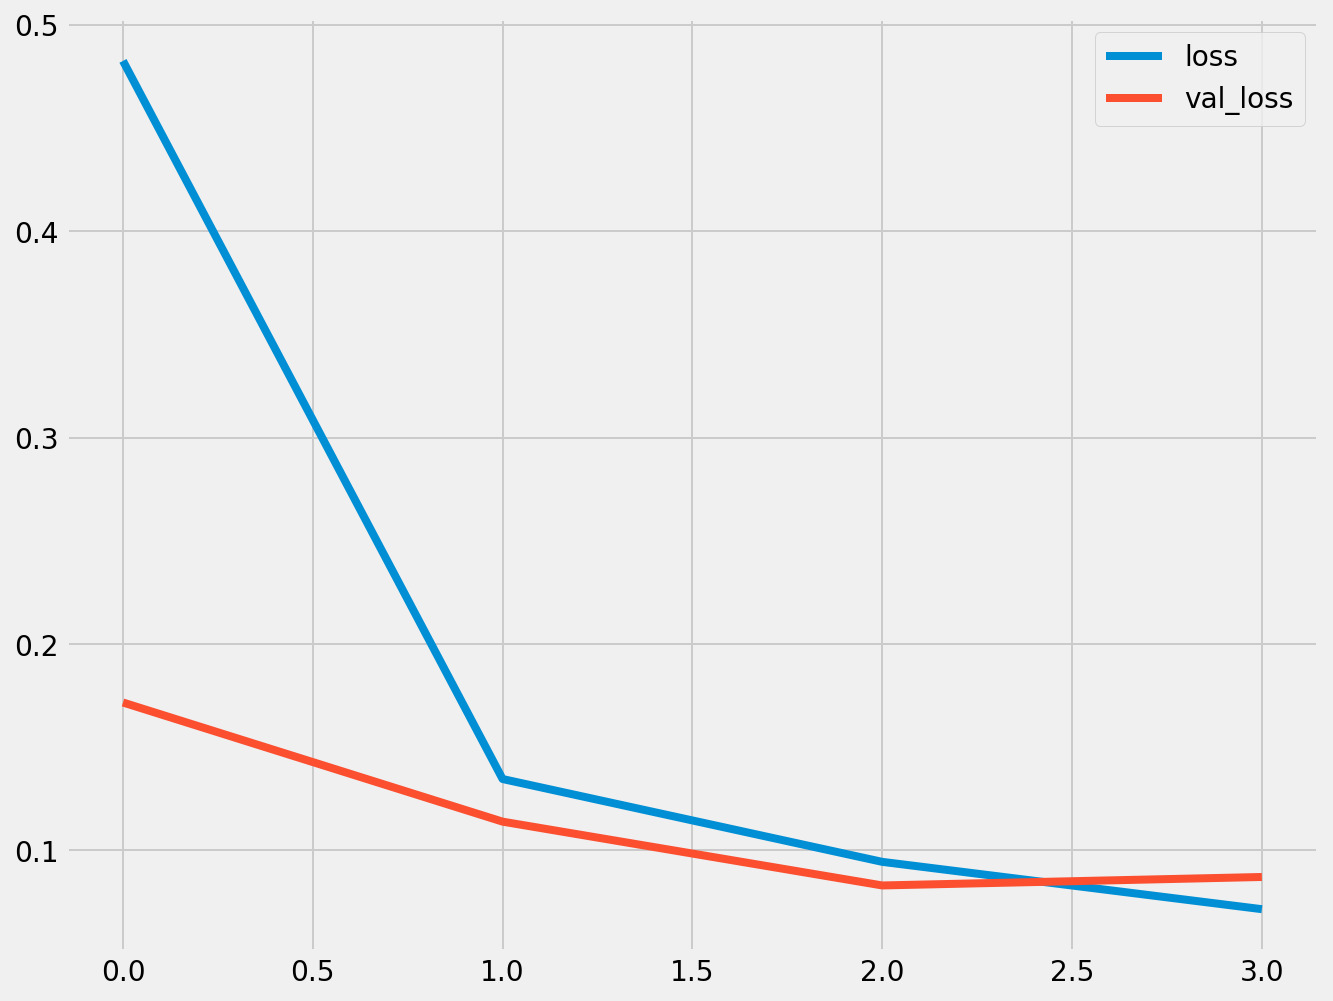

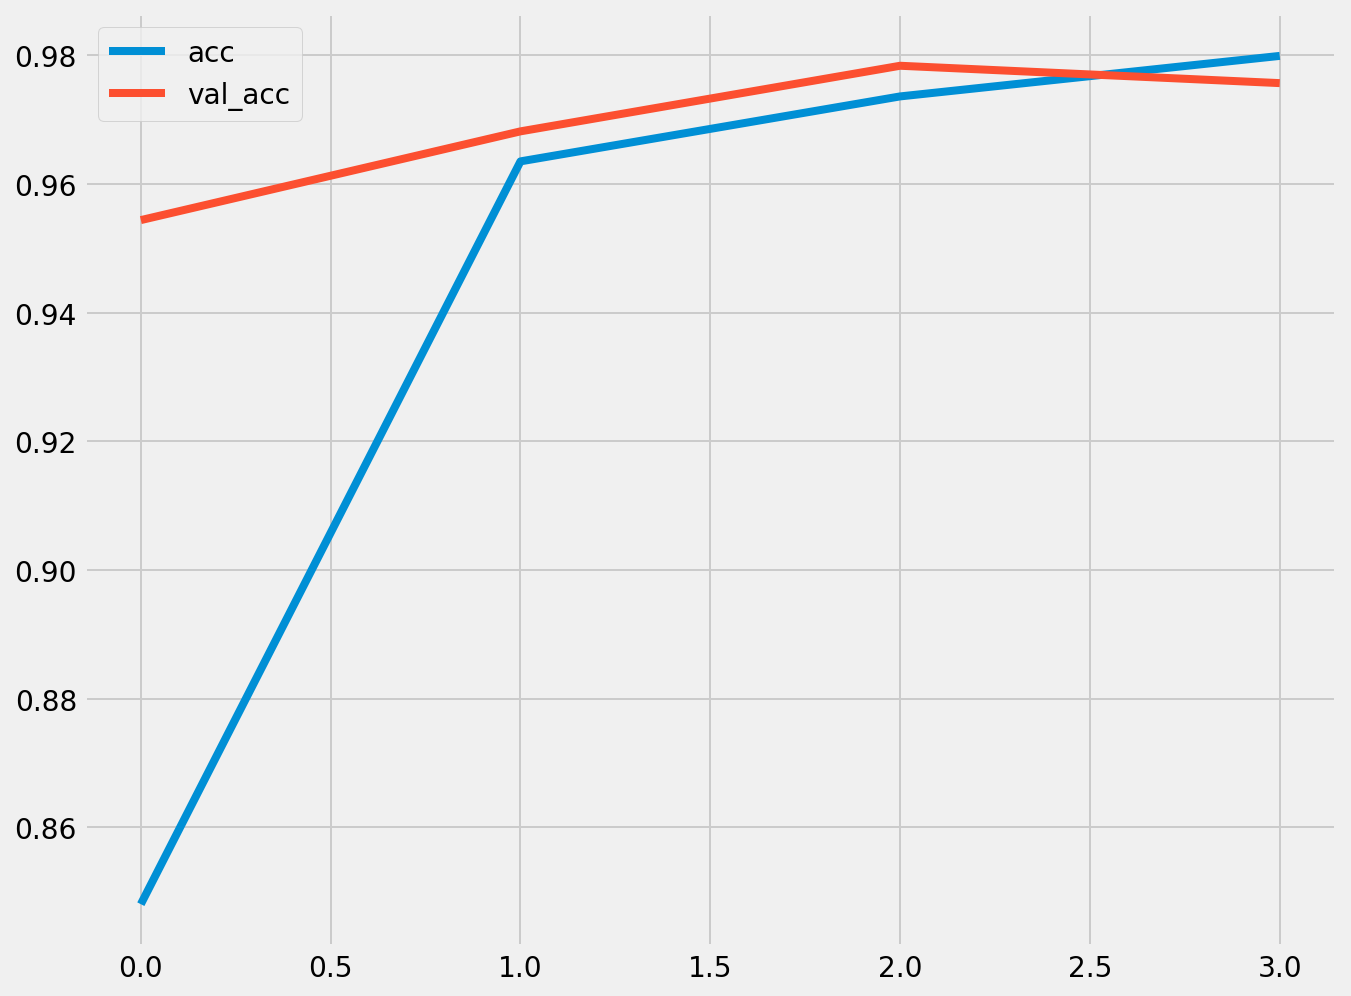

In [42]:
# config
D = 28
M = 200


# input is an image of size 28x28
input_ = Input(shape=(D, D))
print('input shape is:', input_.shape)

# up-down
rnn1 = Bidirectional(LSTM(M, return_sequences=True))
x1 = rnn1(input_) # output is N x D x 2M
print('shape after putting the first one through lstm:', x1.shape)
x1 = GlobalMaxPooling1D()(x1) # output is N x 2M
print('shape after taking the maximum value:', x1.shape)

# left-right
rnn2 = Bidirectional(LSTM(M, return_sequences=True))

# custom layer
permutor = Lambda(lambda t: K.permute_dimensions(t, pattern=(0, 2, 1)))
x2 = permutor(input_)
print('after transposing each image, we get a output like', x2, 'with a shape', x2.shape)
x2 = rnn2(x2) # output is N x D x 2M
print('shape after putting the second one through lstm:', x2.shape)
x2 = GlobalMaxPooling1D()(x2) # output is N x 2M
print('shape after taking the maximum value:', x2.shape)
# put them together
concatenator = Concatenate(axis=1)
x = concatenator([x1, x2]) # output is N x 4M
print('shape after concatenation', x.shape)
# final dense layer
output = Dense(10, activation='relu')(x)
output = Dense(10, activation='softmax')(output)
print('shape of output',output.shape)
model = Model(inputs=input_, outputs=output)

# testing
# o = model.predict(X)
# print("o.shape:", o.shape)

# compile
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

# train
print('Training model...')
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
mc = ModelCheckpoint('best_model_a6.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
r = model.fit(X_train_, y_train_, batch_size = 64, epochs = 50, validation_data=(X_test_, y_test_), verbose=0, callbacks=[es, mc])
#history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test)) 


# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()